# DTI-derived metrics (FA, MD, AD, RD) within FS-segmented ROIs

`06-diff-dipy-dti-feature-extraction-roi-wise.ipynb` ver. 20200422

**Check [FreeSurferColorLUT.txt](https://surfer.nmr.mgh.harvard.edu/fswiki/FsTutorial/AnatomicalROI/FreeSurferColorLUT) for the ROI-label for the different regions (left and right hemisphere)**

In [1]:
from IPython.display import Image
#Image("assets/dipy_image_registration_ants.png")

In [2]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from os.path import expanduser, join, basename, split
home = expanduser('~') # To make path to local home directory
import time
from dipy.io.image import save_nifti

In [3]:
def get_dti_features_from_roi(inpdir, sub, ses, roi_name, roi_num, outdir):
    r"""
    Extraction of DTI-derived featurevalues, i.e. FA, MD, AD, RD from a given antomical region, named 'roi_name'
    and numbered by Freesurfer as 'roi_num' with respect to the coregistered wmparc segmented image for 
    given subject ('sub') and session ('ses' = 1) 

    Parameters
    ----------
    inpdir     : input directory e.g. inpdir = '~/prj/BrainGut/GE_Signa3T/dipy_analysis' where the moving files from Freesurfer segmentation mapped to T1w native space are stored.
    sub        : subject id, e.g. 101 for sub-101
    ses        : session number, e.g. 1 for ses-1
    roi_name   : name of a (white matter) region in wmparc, e.g. 'wm-lh-insula'
    roi_num    : number of that region according to the Freesurfer LUT, e.g. 3035
    outdir     : output directory e.g. outdir = inpdir, where resulting ... are stored,

    Returns
    -------
    meas_name  : list of DTI-derived features, for now ['fa', 'md', 'ad', 'rd']
    meas_num   : number of voxels in the named 3D ROI region (same accross all features)
    meas_val   : the feature values of each feature i in ['fa', 'md', 'ad', 'rd']


    Notes
    -----
    sub-115_ses-1 is problematic:
    
    % 115 -  dicm2nii:
    % Validating 14627 files ...
    %  Inconsistent 'ImageOrientationPatient' for Subject fMRI_120411_suppe_rhs, ny loc (Series 6). Series skipped.
    %  Inconsistent 'ImageOrientationPatient' for Subject fMRI_120411_suppe_rhs, loc (Series 1). Series skipped.
    % Converting 5 series (GE) into 4-D .nii.gz: subject 'fMRI_120411_suppe_rhs'
    %  x3DT1_SPGRE_192_z_192_x_Te_min_full_s002             188x256x256x1
    %  fMRI_default_s003                                    128x128x25x240
    %  TENSOR_ASSET                                         128x128x55x36
    %  x3DT1_SPGRE_192_z_192_x_Te_min_full_s007             188x256x256x1
    %  fMRI_default_s008                                    128x128x26x240
    % Elapsed time by dicm2nii is 10.2 seconds
    
    ── 115
    ├── dcmHeaders.mat
    ├── dicm2nii_warningMsg.txt
    ├── fMRI_default_s003.json
    ├── fMRI_default_s003.nii.gz
    ├── fMRI_default_s008.json
    ├── fMRI_default_s008.nii.gz
    ├── TENSOR_ASSET.bval
    ├── TENSOR_ASSET.bvec
    ├── TENSOR_ASSET.json
    ├── TENSOR_ASSET.nii.gz
    ├── x3DT1_SPGRE_192_z_192_x_Te_min_full_s002.json
    ├── x3DT1_SPGRE_192_z_192_x_Te_min_full_s002.nii.gz
    ├── x3DT1_SPGRE_192_z_192_x_Te_min_full_s007.json
    └── x3DT1_SPGRE_192_z_192_x_Te_min_full_s007.nii.gz
    """
    
    # Preparations
    
    # Load WMPARC: 
    wmparc_fn = join(inpdir, 'sub_%d_tp%d_wmparc_in_native_space_aff_to_dwi_S0_mean.nii.gz' % (sub, ses))
    wmparc_img= nib.load(wmparc_fn)
    wmparc_data = wmparc_img.get_fdata()
    wmparc_affine = wmparc_img.affine
    
    #a = wmparc_data.flatten()
    #unique, counts = np.unique(a, return_counts=True)
    #dict(zip(unique, counts))
    
    roi = np.where(wmparc_data == roi_num)
    roi_flatten = np.where(wmparc_data.flatten() == roi_num)
    
    # Metrics from DTI in native DWI space
    dti_metrics = ['fa', 'md', 'ad', 'rd']
    meas_name = []
    meas_num = []
    meas_val = []
    for i, meas in enumerate(dti_metrics):
        fname = join(inpdir, 'sub_%d_tp%d_dwi_brainmask_tensor_%s.nii.gz' % (sub, ses, meas))
        meas_img= nib.load(fname)
        meas_data = meas_img.get_fdata()
        meas_affine = meas_img.affine
        
        meas_data_flatten = meas_data.flatten()
        
        meas_name.append(meas)
        meas_num.append(len(roi_flatten[0]))
        meas_val.append(meas_data_flatten[roi_flatten])
        
        #plt.hist(meas_val[i],bins=50)
        #plt.title('sub-%d | %s | %s | n=%d' % (sub, roi_name, meas_name[i], len(roi_flatten[0])))
        #plt.show()
        
    
    #fig = plt.figure(figsize = [14, 12])
    #for i, meas in enumerate(dti_metrics):
    #    plt.subplot(2,2,i+1)
    #    plt.hist(meas_val[i],bins=50, color='black')
    #    plt.title('sub-%d | %s | %s | n=%d | median=%.5f' %
    #              (sub, roi_name, meas_name[i].upper(), len(roi_flatten[0]), np.median(meas_val[i])))
    #plt.show()
    #fig.savefig('%s/tmp/FIGURES/sub_%d_wmparc_%s_dti_features.png' % (home, sub, roi_name),
    #       transparent=False, dpi=300, bbox_inches="tight")
    
    return dti_metrics, meas_name, meas_num, meas_val


### Test the function

In [4]:
working_dir = join(os.getcwd(), 'data')
inp_dir = '%s/dipy_analysis' % (working_dir)
outp_dir = inp_dir
roi_name = 'wm-lh-insula'
roi_num = 3035
sub = 101
ses = 1

In [5]:
%%time
dti_metrics, meas_name, meas_num, meas_val = get_dti_features_from_roi(inp_dir, sub, ses, roi_name, roi_num, outp_dir)

CPU times: user 52.4 ms, sys: 8.05 ms, total: 60.5 ms
Wall time: 59.9 ms


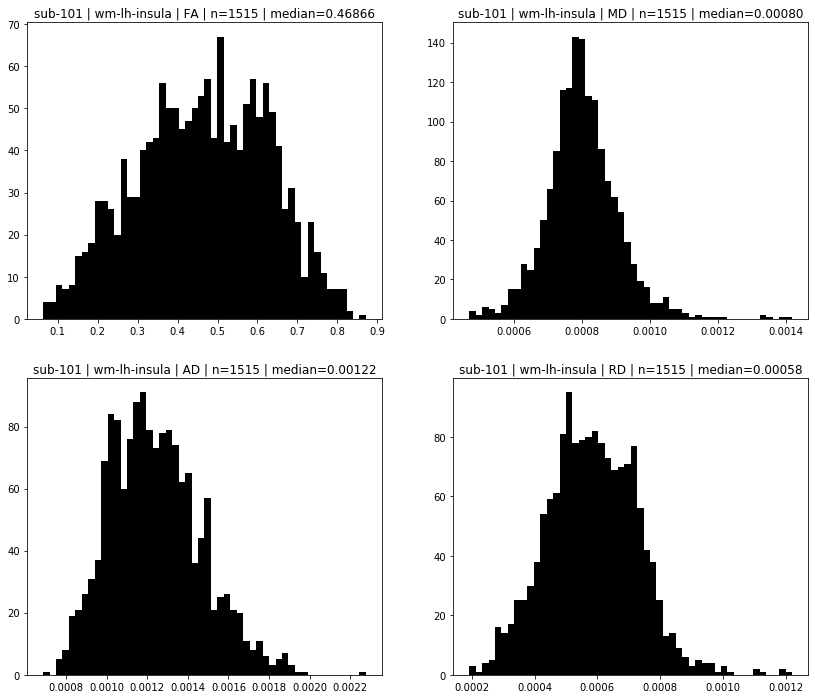

In [6]:
fig = plt.figure(figsize = [14, 12])
for i, meas in enumerate(dti_metrics):
    plt.subplot(2,2,i+1)
    plt.hist(meas_val[i],bins=50, color='black')
    plt.title('sub-%d | %s | %s | n=%d | median=%.5f' %
                  (sub, roi_name, meas_name[i].upper(), len(meas_val[i]), np.median(meas_val[i])))
plt.show()
fig.savefig('./assets/sub_%d_wmparc_%s_dti_features.png' % (sub, roi_name),
           transparent=False, dpi=300, bbox_inches="tight")

In [7]:
# get_dti_features_from_roi?

## Run for all subjects

In [8]:
import sys
sys.path.append('.')   # path to utils.py
import utils
import time

working_dir = join(os.getcwd(), 'data')
inp_dir = '%s/dipy_analysis' % (working_dir)
outp_dir = inp_dir
roi_name = 'wm-lh-insula'
roi_num = 3035

In [9]:
%%time
nsubj = 1 # 30
ses=1

for i in utils.progressbar(range(nsubj), "Computing: ", 40):
    time.sleep(0.1)
    sub = i+101
    
    dti_metrics, meas_name, meas_num, meas_val = get_dti_features_from_roi(inp_dir, sub, ses, roi_name, roi_num, outp_dir)


Computing: [########################################] 1/1
CPU times: user 57.8 ms, sys: 8.1 ms, total: 65.9 ms
Wall time: 165 ms
